# Example use of bag of visual words model for classification

- [Overview](#Overview-of-model)
- [Dictionary training](#Dictionary-training)
- [SIFT detection and computation](#SIFT-feature-detection-and-computation)
- [Converting SIFT features to "words"](#Converting-SIFT-features-to-"word"-histograms)
- [Classifier model training](#Classifier-model-training)
- [Accuracy of model](#Classification-accuracy)
- [Examples of sift descriptors](#Sift-Descriptor-Examples)
- [Centroid clusters](#Clusters-of-K-Means-centroids)

In [1]:
%reload_ext autoreload
%autoreload 2

In [196]:
import os
import pandas as pd
import numpy as np
import bagofvisualwords as bovw
import plotly
import plotly.graph_objs as pgo
import plotly.figure_factory as FF
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import math

## Overview of model 

![bag-of-words-model](https://i.stack.imgur.com/yfA1C.png)

In [4]:
cal256_metadata_file = os.path.join('..', 'data', 'cal256_file_reference.csv')
cal256_metadata = pd.read_csv(cal256_metadata_file, index_col=0)

In [5]:
cal256_metadata.columns

Index(['class_name', 'class', 'file_loc'], dtype='object')

In [6]:
cal256_metadata['class_name'].unique()

array(['ak47', 'american-flag', 'backpack', 'baseball-bat',
       'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear',
       'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp',
       'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin',
       'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101',
       'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel',
       'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede',
       'cereal-box', 'chandelier-101', 'chess-board', 'chimp',
       'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet',
       'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch',
       'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101',
       'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101',
       'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower',
       'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101',
       'eyeglasses', 'fern', 'fighter-jet', 'fire-e

In [7]:
# let's go with toads and owls

In [8]:
toads = cal256_metadata.loc[cal256_metadata['class_name'] == 'toad', :]
owls = cal256_metadata.loc[cal256_metadata['class_name'] == 'owl', :]

In [9]:
toad_ims = [(cv2.imread(toads.loc[idx, 'file_loc'], cv2.IMREAD_GRAYSCALE), toads.loc[idx, 'class']) for idx in toads.index]
owl_ims = [(cv2.imread(owls.loc[idx, 'file_loc'], cv2.IMREAD_GRAYSCALE), owls.loc[idx, 'class']) for idx in owls.index]

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

### SIFT feature detection and computation

![SIFT-overview](http://ispl.korea.ac.kr/Research/datafusion/pics/sift.gif)
[Image from this page](http://ispl.korea.ac.kr/)

In [11]:
%%time
# get SIFT descriptors for each image

toad_descriptors = []
owl_descriptors = []



for ti in toad_ims:
    im_data = ti[0]
    im_class = ti[1]
    (kp, des) = sift.detectAndCompute(im_data, None)
    toad_descriptors.append(((kp, des), im_class))
    
for oi in owl_ims:
    im_data = oi[0]
    im_class = oi[1]
    (kp, des) = sift.detectAndCompute(im_data, None)
    owl_descriptors.append(((kp, des), im_class))
    
    
toad_train, toad_test = train_test_split(toad_descriptors, train_size=0.6)
owl_train, owl_test = train_test_split(owl_descriptors, train_size=0.6)

CPU times: user 43.1 s, sys: 5.94 s, total: 49 s
Wall time: 47.6 s


In [12]:
all_training_descriptors = [x[0][1] for x in toad_train] + [x[0][1] for x in owl_train]
all_training_descriptors = np.concatenate(all_training_descriptors, axis=0)

In [13]:
all_training_descriptors.shape

(274023, 128)

In [14]:
toad_owl_bovw = bovw.BOVW()

### Dictionary training

Here we are in the clustering phase. One way to think of this is we are taking all the SIFT descriptors from all the images and generating a vocabulary that we can use to describe them generally. In this case, the vocabulary will consist of thirty words.

In [15]:
%%time
toad_owl_bovw.fit_dictionary(all_training_descriptors, model=KMeans(n_clusters=30, n_jobs=-1))

CPU times: user 2.63 s, sys: 313 ms, total: 2.95 s
Wall time: 1min 32s


### Converting SIFT features to "word" histograms

In this step, we convert the bag of SIFT features to a bag of "words" from the vocabulary we developed in the last step. We then convert that to a histogram of words, which we will use to train and test the classifier model.

In [16]:
%%time
toad_train_hist = [(toad_owl_bovw.predict_dictionary_and_convert_to_counts(x[0][1]), x[1]) for x in toad_train]
owl_train_hist = [(toad_owl_bovw.predict_dictionary_and_convert_to_counts(x[0][1]), x[1]) for x in owl_train]

toad_test_hist = [(toad_owl_bovw.predict_dictionary_and_convert_to_counts(x[0][1]), x[1]) for x in toad_test]
owl_test_hist = [(toad_owl_bovw.predict_dictionary_and_convert_to_counts(x[0][1]), x[1]) for x in owl_test]

CPU times: user 732 ms, sys: 104 ms, total: 836 ms
Wall time: 421 ms


In [17]:
toad_train_hist[1][0].shape

(30,)

In [18]:
X_train = pd.DataFrame([x[0] for x in toad_train_hist] + [x[0] for x in owl_train_hist])
X_test = pd.DataFrame([x[0] for x in toad_test_hist] + [x[0] for x in owl_test_hist])

In [19]:
X_train.shape

(136, 30)

In [20]:
y_train = pd.Series([x[1] for x in toad_train_hist] + [x[1] for x in owl_train_hist])
y_test = pd.Series([x[1] for x in toad_test_hist] + [x[1] for x in owl_test_hist])

In [21]:
toad_owl_bovw.fit(X_train.replace(np.nan, 0.0).astype(np.float32), y_train.astype(np.float32).values)

In [22]:
toad_owl_bovw.classifier_model.score(X_train.astype(np.float32), y_train.astype(np.float32).values)

1.0

In [23]:
toad_owl_bovw.classifier_model.score(X_test.astype(np.float32),
                                     y_test.astype(np.float32).values)

0.72826086956521741

### Classifier model training

Now that each image is represented as a histogram of the thirty "words" we defined earlier, we train a [random forest classifer model](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) to learn what patterns of "word" frequencies are associated with toads and owls. In this case I used a random forest classifier because it tends to be robust and quick to train and test, however any classifier model could be used, for example support vector machines, logisitic regression, neural network etc.

In [24]:
cvm = toad_owl_bovw.cross_validate_classifier_model(X_train.values, y_train.values, verbose=1)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   45.9s finished


In [25]:
cvm.best_score_

0.7279411764705882

In [26]:
cvm.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Classification accuracy

Pretty good for just throwing the whole image at the classifier, may be able to get better performance
when training on uncluttered images, images that have undergone similar pre-processing etc.

In [27]:
cvm.best_estimator_.score(X_test.astype(np.float32),
                          y_test.astype(np.float32))

0.79347826086956519

### Sift Descriptor Examples

These images could be made better for training. I made no effort to segment, normalize or preprocess the training images. Even despite that, the accuracy of the classifier was still 75% on the test set. In addition, I also made no attempt to use the spatial relationships of the SIFT descriptors or other properties to give more specificity to the sift features per image type. The approach shown here is as simple as it can get - I just treated each image as a bag of SIFT features.

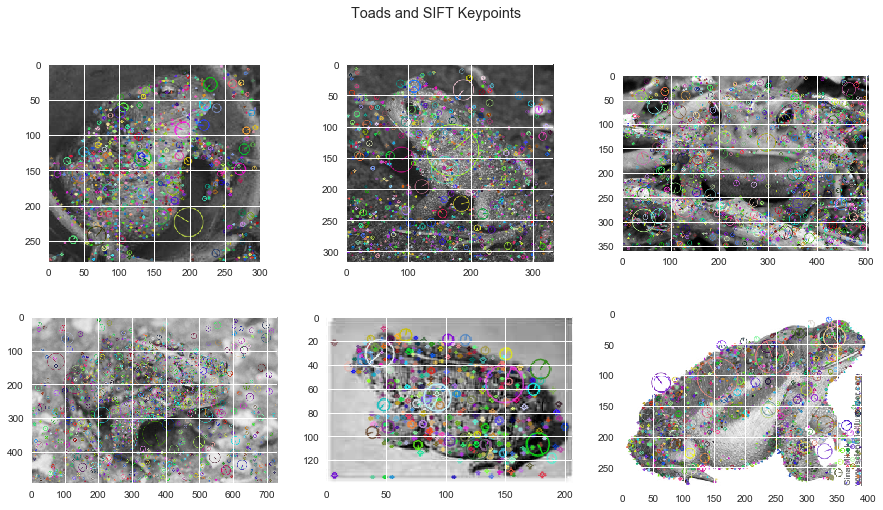

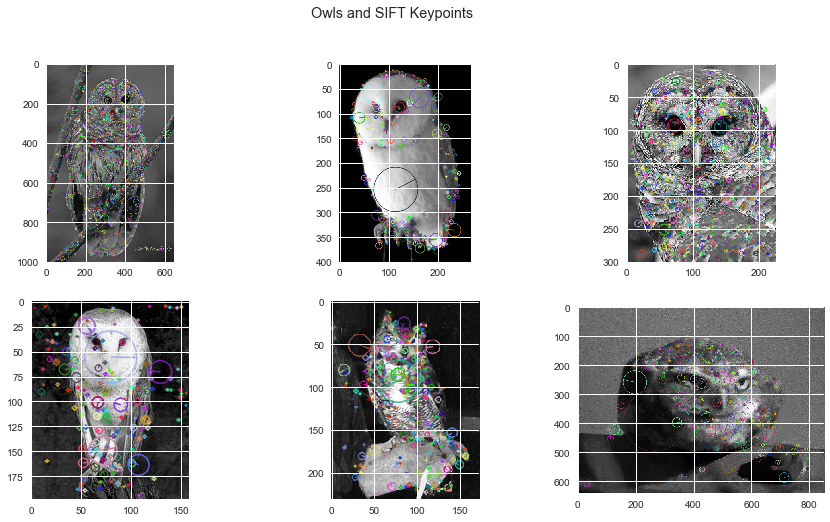

In [28]:
fig, axarr = plt.subplots(2,3, figsize=(15, 8))
axarr = axarr.ravel()

for enum, t_ex in enumerate(zip(toad_ims[0:6], toad_descriptors[0:6])):
    gray_im = t_ex[0][0]
    kps = t_ex[1][0][0]
    outim = gray_im
    outim = cv2.drawKeypoints(gray_im, kps,outim, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axarr[enum].imshow(outim)

fig.suptitle('Toads and SIFT Keypoints')
plt.show()
    
fig, axarr = plt.subplots(2,3, figsize=(15, 8))  
axarr = axarr.ravel()
for enum, o_ex in enumerate(zip(owl_ims[0:6], owl_descriptors[0:6])):
    gray_im = o_ex[0][0]
    kps = o_ex[1][0][0]
    outim = gray_im
    outim = cv2.drawKeypoints(gray_im, kps,outim, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    axarr[enum].imshow(outim)
    
fig.suptitle("Owls and SIFT Keypoints")
plt.show()

In [29]:
# let's give a simple example of the k-means clusters

In [30]:
toad_owl_bovw.dictionary_model.cluster_centers_.shape

(30, 128)

In [31]:
pca = PCA(n_components=2)
cc_pca = pca.fit_transform(toad_owl_bovw.dictionary_model.cluster_centers_)

### Clusters of K-Means centroids

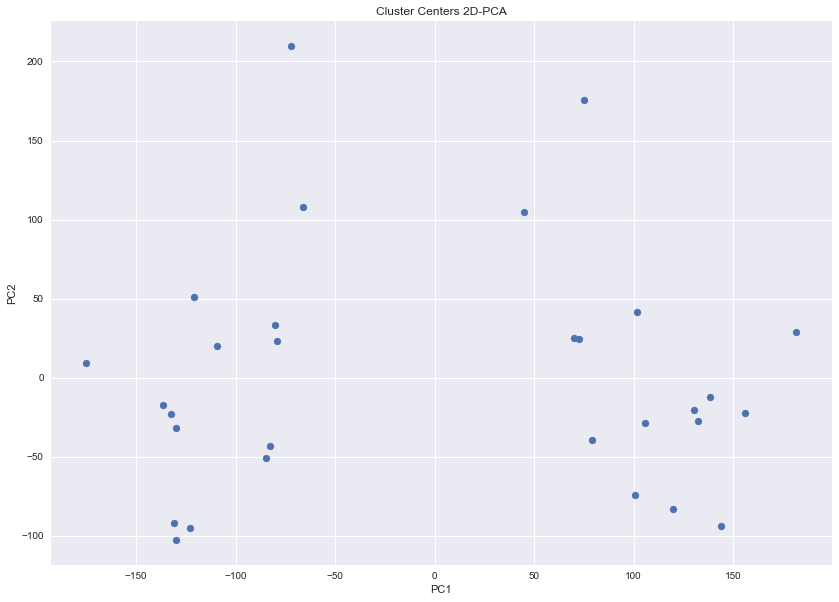

In [32]:
fig = plt.figure(figsize=(14,10))
plt.title("Cluster Centers 2D-PCA")
plt.scatter(cc_pca[:, 0], cc_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

/Users/antalek/anaconda/envs/ENVPy3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning:

The axisbg attribute was deprecated in version 2.0. Use facecolor instead.



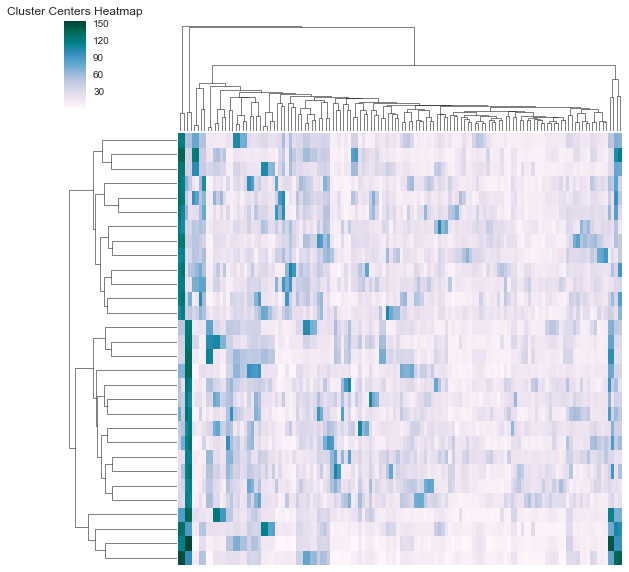

In [33]:
fig = plt.figure(figsize=(14,10))
sns.clustermap(toad_owl_bovw.dictionary_model.cluster_centers_,
               cmap='PuBuGn',
               xticklabels=False,
               yticklabels=False)
plt.title('Cluster Centers Heatmap')
plt.show()

In [34]:
# let's test locating an object in an image

In [35]:
toad_ims[1]

(array([[ 69,  68,  67, ...,  52,  52,  52],
        [ 71,  68,  66, ...,  48,  48,  48],
        [ 71,  67,  64, ...,  44,  44,  44],
        ..., 
        [ 70,  56,  51, ...,  63,  66,  66],
        [ 84,  78,  66, ...,  70,  83,  92],
        [ 97, 103,  84, ...,  82, 102, 118]], dtype=uint8), 256)

In [39]:
kps = toad_descriptors[1][0][0]

In [41]:
z = kps[0]

In [42]:
z.pt

(120.47639465332031, 20.310827255249023)

In [43]:
z.size

2.4067776203155518

<KeyPoint 0x1189b5690>

In [47]:
len(kps)

1263

In [50]:
x = toad_descriptors[1][0][1]

In [51]:
x.shape

(1263, 128)

In [54]:
xl = x.tolist()

In [55]:
len(xl)

1263

In [56]:
len(xl[0])

128

In [59]:
z = kps[0]

In [60]:
z.pt

(120.47639465332031, 20.310827255249023)

In [61]:
kp_locs = [z.pt for z in kps]

In [62]:
all_descriptors = toad_descriptors[1][0][1]

In [63]:
descriptors = [all_descriptors[i, :] for i in range(all_descriptors.shape[0])]

In [67]:
toad_ims[1][0].shape

(317, 332)

In [68]:
toad_im_to_use = toad_ims[1][0]

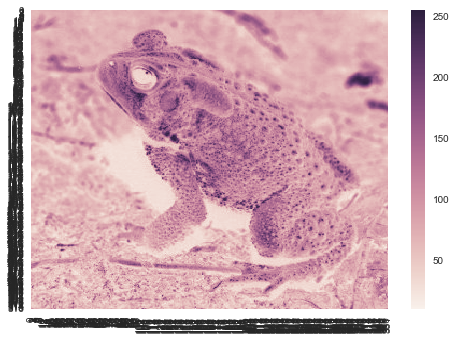

In [161]:
sns.heatmap(toad_im_to_use)
plt.show()

In [309]:
# 70% patch size
min_patch_size = (int(math.floor(toad_im_to_use.shape[1] * 0.1)),
                  int(math.floor(toad_im_to_use.shape[0] * 0.1)))

max_patch_size = (int(math.floor(toad_im_to_use.shape[1] * 0.3)),
                  int(math.floor(toad_im_to_use.shape[0] * 0.3)))

In [310]:
min_patch_size, max_patch_size

((33, 31), (99, 95))

In [311]:
toad_im_to_use.shape

(317, 332)

In [312]:
det = toad_owl_bovw.detect_object_in_image(kp_locs, 
                                           descriptors, 
                                           toad_im_to_use.shape,
                                           min_patch_size,
                                           max_patch_size,
                                           1.05, 
                                           0.1, 
                                           0.1)

In [313]:
det

[(152.0, (0, 31, 0, 33)),
 (152.0, (0, 31, 3, 36)),
 (152.0, (0, 31, 6, 39)),
 (152.0, (0, 31, 9, 42)),
 (152.0, (0, 31, 12, 45)),
 (152.0, (0, 31, 15, 48)),
 (152.0, (0, 31, 63, 96)),
 (152.0, (0, 31, 66, 99)),
 (152.0, (0, 31, 69, 102)),
 (152.0, (0, 31, 72, 105)),
 (152.0, (0, 31, 75, 108)),
 (152.0, (0, 31, 78, 111)),
 (152.0, (0, 31, 81, 114)),
 (152.0, (0, 31, 84, 117)),
 (152.0, (0, 31, 87, 120)),
 (152.0, (0, 31, 90, 123)),
 (152.0, (0, 31, 93, 126)),
 (152.0, (0, 31, 96, 129)),
 (152.0, (0, 31, 99, 132)),
 (152.0, (0, 31, 102, 135)),
 (152.0, (0, 31, 105, 138)),
 (152.0, (0, 31, 108, 141)),
 (152.0, (0, 31, 111, 144)),
 (152.0, (0, 31, 114, 147)),
 (152.0, (0, 31, 117, 150)),
 (152.0, (0, 31, 120, 153)),
 (152.0, (0, 31, 123, 156)),
 (152.0, (0, 31, 126, 159)),
 (152.0, (0, 31, 129, 162)),
 (152.0, (0, 31, 132, 165)),
 (152.0, (0, 31, 135, 168)),
 (152.0, (0, 31, 138, 171)),
 (152.0, (0, 31, 153, 186)),
 (152.0, (0, 31, 156, 189)),
 (152.0, (0, 31, 159, 192)),
 (152.0, (0, 31,

In [314]:
con = toad_owl_bovw.consolidate_object_locations(det, 
                                                 256.0)

In [315]:
con

[(0, 331, 0, 315)]

In [316]:
toad_im_to_use.shape

(317, 332)

In [306]:
con[1]

IndexError: list index out of range

In [307]:
import matplotlib.patches as patches

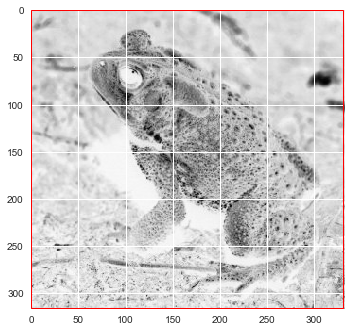

In [308]:
fig,ax = plt.subplots(1)
ax.imshow(toad_im_to_use)

rect = patches.Rectangle((con[0][0], con[0][2]), con[0][1]-con[0][0], con[0][3]-con[0][2], linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [317]:
toad_im_to_use.shape

(317, 332)

In [322]:
new_picture = np.zeros((1000,1000), dtype=toad_im_to_use.dtype)
x_start = int(math.floor(500 - toad_im_to_use.shape[1]/2))
x_end = x_start + toad_im_to_use.shape[1]
y_start = int(math.floor(500 - toad_im_to_use.shape[0]/2))
y_end = y_start + toad_im_to_use.shape[0]

new_picture[y_start:y_end, x_start:x_end] = toad_im_to_use

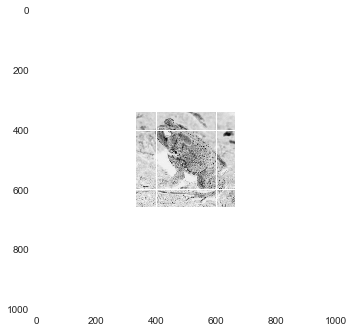

In [323]:
fig,ax = plt.subplots(1)
ax.imshow(new_picture)
plt.show()

In [324]:
kp, des = sift.detectAndCompute(new_picture, None)

In [325]:
kps = [z.pt for z in kp]

In [327]:
deslist = [des[i,:] for i in range(des.shape[0])]

In [332]:
# 70% patch size
min_patch_size = (int(math.floor(toad_im_to_use.shape[1] * 0.05)),
                  int(math.floor(toad_im_to_use.shape[0] * 0.05)))

max_patch_size = (int(math.floor(toad_im_to_use.shape[1] * 0.1)),
                  int(math.floor(toad_im_to_use.shape[0] * 0.1)))

In [333]:
det = toad_owl_bovw.detect_object_in_image(kps, 
                                           deslist, 
                                           new_picture.shape,
                                           min_patch_size,
                                           max_patch_size,
                                           1.05, 
                                           0.1, 
                                           0.1)

In [334]:
con = toad_owl_bovw.consolidate_object_locations(det, 
                                                 256.0)

In [335]:
con

[(348, 655, 324, 654)]

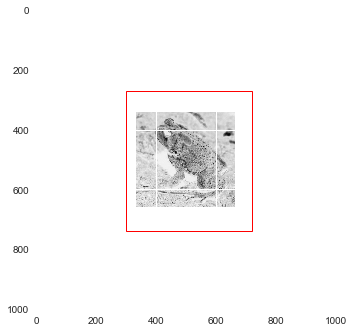

In [331]:
fig,ax = plt.subplots(1)
ax.imshow(new_picture)

rect = patches.Rectangle((con[0][0], con[0][2]), con[0][1]-con[0][0], con[0][3]-con[0][2], linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()